In [7]:
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime

# bokeh libraries
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, output_file
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, Legend, HoverTool
from bokeh.plotting import figure, show
import seaborn as sns

#set rendering to notebook
output_notebook()

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

path = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip"
df = pd.read_csv(path,compression='zip', skiprows=51, low_memory=False)
df.head()

Loading BokehJS ...

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19010101,,,,,,,,,...,,,,,66,,,,,
1,260,19010102,,,,,,,,,...,,,,,86,,,,,
2,260,19010103,,,,,,,,,...,,,,,89,,,,,
3,260,19010104,,,,,,,,,...,,,,,79,,,,,
4,260,19010105,,,,,,,,,...,,,,,65,,,,,


In [8]:
def preprocess(df):
    """
    preprocess 'de bilt etmaalgegevens' for analysis
    
    parameters: raw dataframe
    returns: cleaned dataframe
    
    """
    #FG = Etmaalgemiddelde windsnelheid (in 0.1 m/s) 
    #TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
    #YYYYMMDD = timestamp
    
    threshold_value = -6.5  

    df = df.rename(columns={"YYYYMMDD": "date", "   TG": "temperature", "   FG": "velosity"}, 
              errors="raise")
    df = df[['date', 'temperature', 'velosity']]
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
    df['temperature'] = df['temperature'].astype('float64')
    df['velosity'] = pd.to_numeric(df['velosity'], errors='coerce')
    df.temperature = df.temperature/10
    df.velosity = df.velosity/10
   
    df.set_index('date', inplace=True)     
    return df

In [9]:
df = preprocess(df)
plt.style.use('dark_background')
subset = df['2020':'2024']

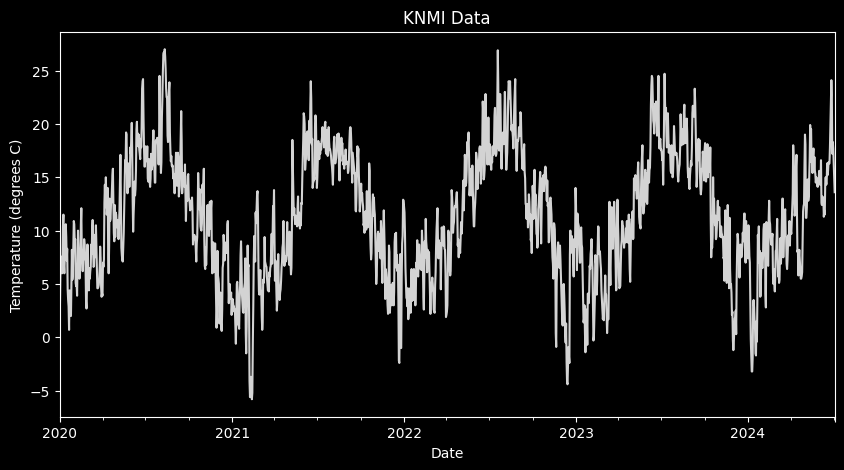

In [10]:
# Plot the temperature data
fig, ax = plt.subplots(figsize=(10, 5))
subset['temperature'].plot(color='lightgrey', ax=ax)

# Set title and labels
ax.set_title("KNMI Data")
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (degrees C)')

# Display the plot


plt.show()

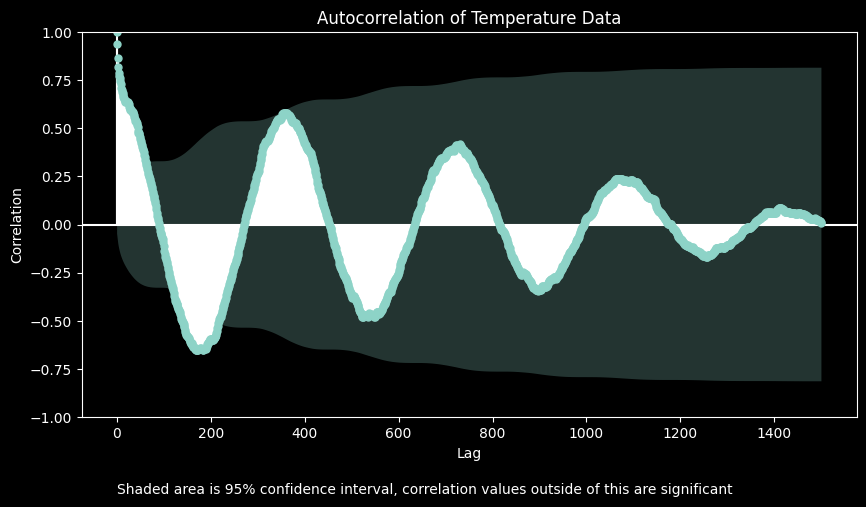

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=1500)
plt.title('Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_largelag.png')
plt.show()

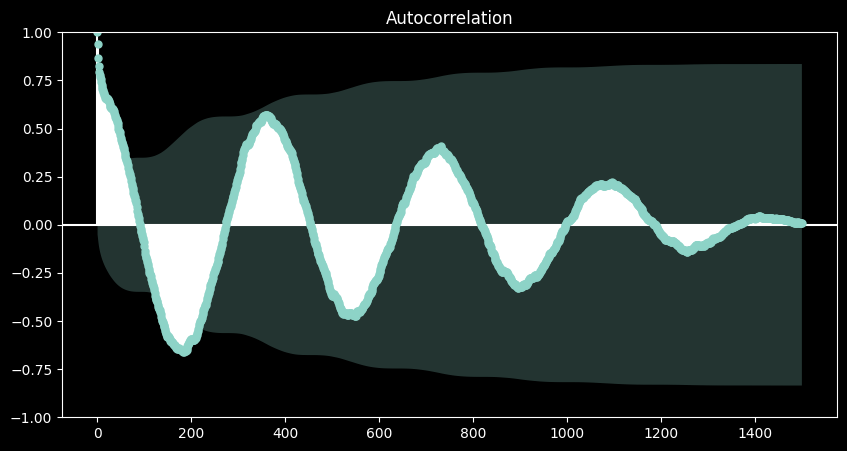

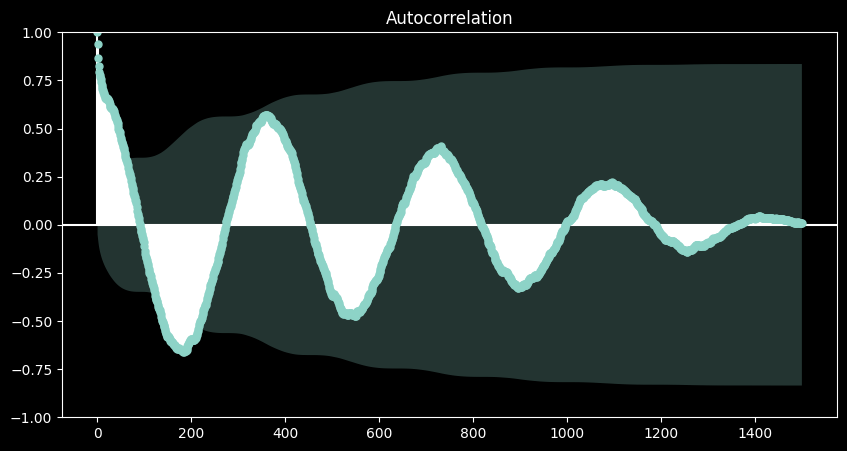

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=1500)

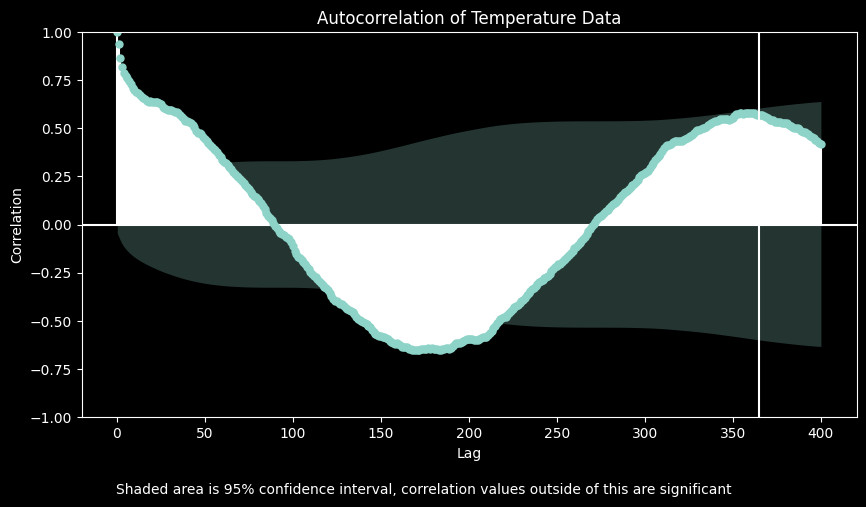

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=400)
plt.vlines(365,-1,1)
plt.title('Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_shortlag.png')
plt.show()

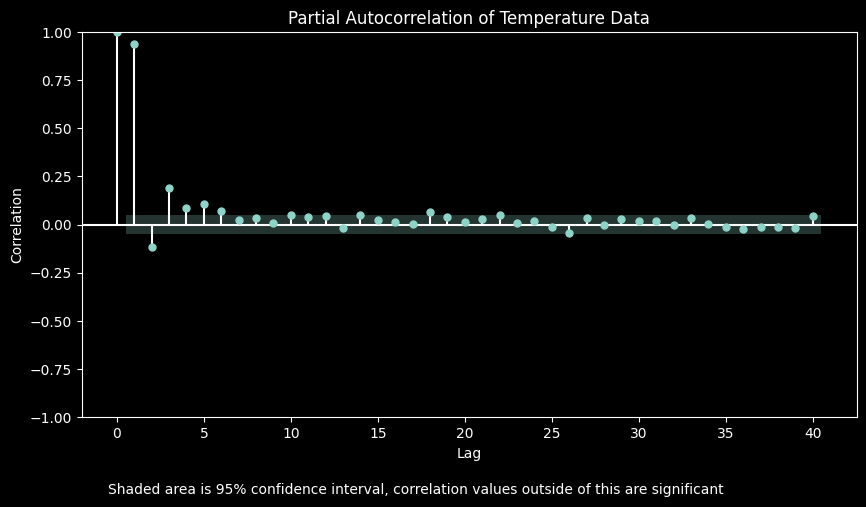

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(subset['temperature'], ax=ax, lags=40)
plt.title('Partial Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')
plt.savefig('partical_autocorrelation_weather_shortlag.png')
plt.show()

In [18]:
k = 20
series = subset['temperature'].rolling(window=k).mean()
series[k:]

date
2020-01-21     6.740
2020-01-22     6.765
2020-01-23     6.570
2020-01-24     6.350
2020-01-25     6.105
               ...  
2024-06-29    16.580
2024-06-30    16.900
2024-07-01    17.120
2024-07-02    17.305
2024-07-03    17.265
Name: temperature, Length: 1626, dtype: float64

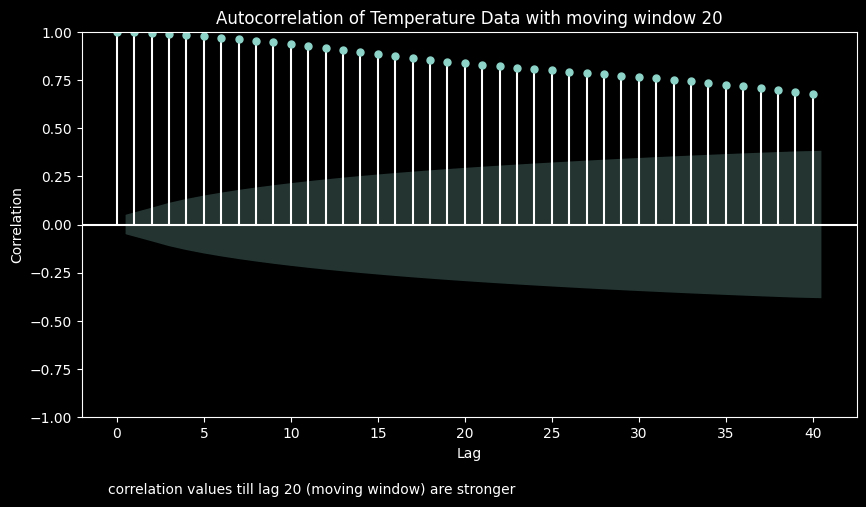

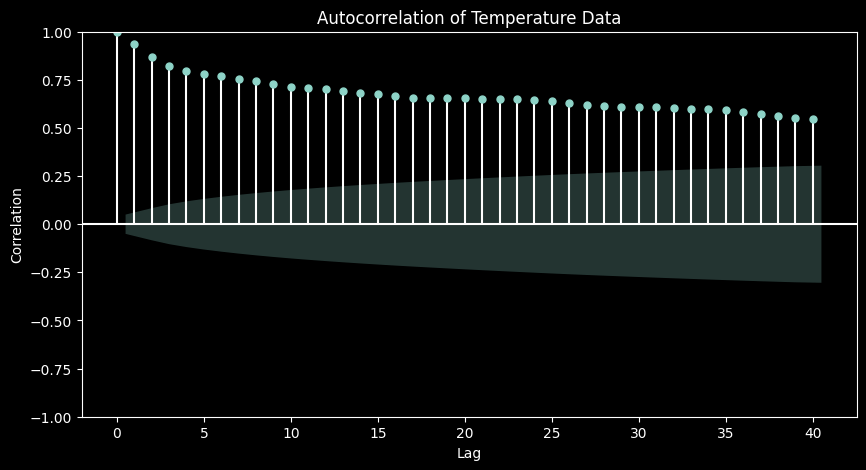

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(series[k:], ax=ax, lags=40)
plt.title(f'Autocorrelation of Temperature Data with moving window {k}')
plt.xlabel('Lag')
plt.ylabel('Correlation')
# Add a text annotation below the plot

plt.text(-0.5, -1.4,
         f'correlation values till lag {k} (moving window) are stronger',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_weather_shortlag_rolling40.png')
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(subset['temperature'], ax=ax, lags=40)
plt.title(f'Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

plt.savefig('40autocorrelation_weather_shortlag40.png')

plt.show()




In [19]:
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(subset['temperature'], model='additive')


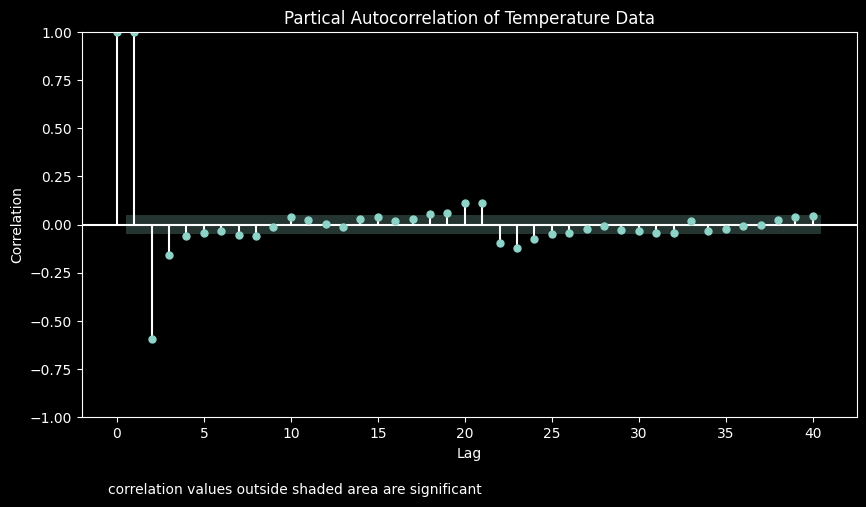

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(series[k:], ax=ax, lags=40)
plt.title('Partical Autocorrelation of Temperature Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.savefig('autocorrelation_weather_shortlag40.png')
# Add a text annotation below the plot

plt.text(-0.5, -1.4,
         f'correlation values outside shaded area are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('partical_autocorrelation_weather_shortlag_rolling.png')

plt.show()

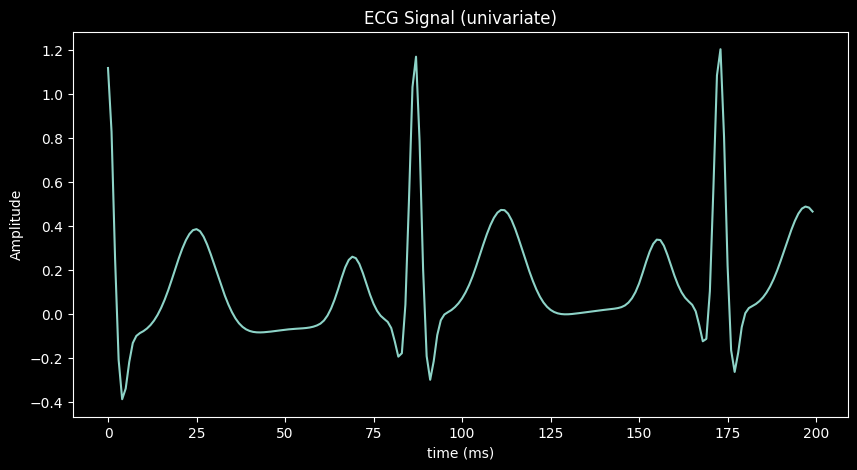

In [21]:
import neurokit2 as nk
import matplotlib.pyplot as plt

# Set the parameters for simulating ECG data
sampling_rate = 100  # Sampling rate in Hz
duration = 10  # Duration of the signal in seconds

# Simulate ECG data
ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate)
# Plot the synthetic ECG signal
plt.figure(figsize=(10, 5))
plt.plot(ecg_signal[:200])
plt.title('ECG Signal (univariate)')
plt.xlabel('time (ms)')
plt.ylabel('Amplitude')
#plt.savefig('ECG.png')
plt.show()

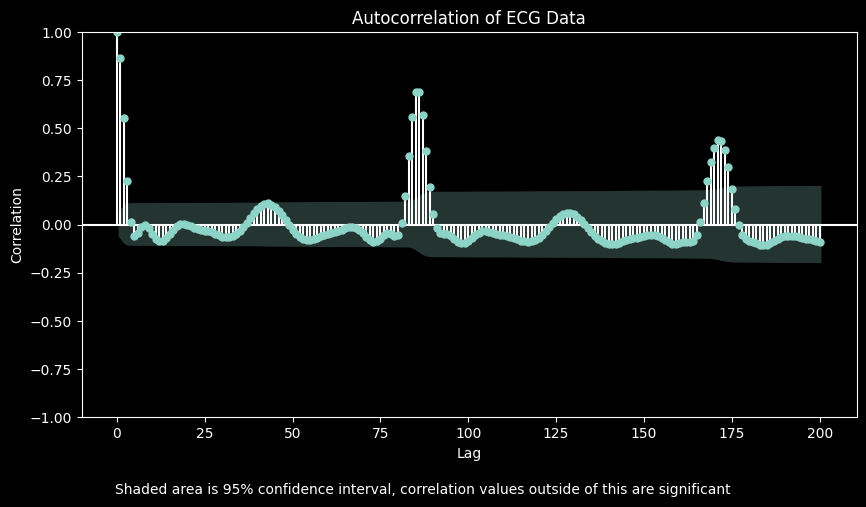

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ecg_signal, ax=ax, lags=200)
plt.title('Autocorrelation of ECG Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('autocorrelation_ecg_largelag.png')
plt.show()

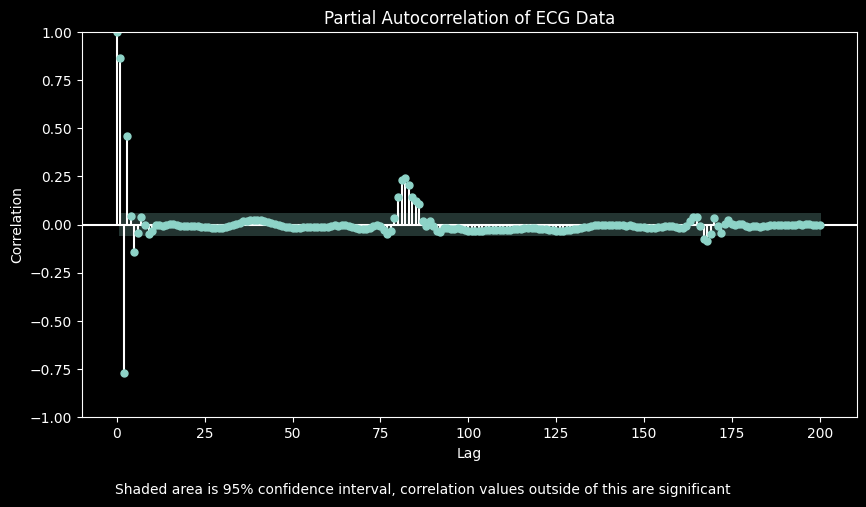

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ecg_signal, ax=ax, lags=200)
plt.title('Partial Autocorrelation of ECG Data')
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Add a text annotation below the plot
plt.text(-0.5, -1.4,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.savefig('partial_autocorrelation_ecg_largelag.png')
plt.show()